This notebook: take what was developed in `N400.ipynb` and sanity-check on the actual Broderick et al 2018 N400 dataset.

In [1]:
import itertools
from pathlib import Path

import mne
import nltk
import numpy as np
import pandas as pd
import re
import scipy.io
from tqdm.notebook import tqdm

# Transformers prep
import os
os.environ["TRANSFORMERS_CACHE"] = str((Path(".") / "transformers_cache").resolve())
import transformers
import torch
RECOMPUTE_SURPRISALS = False

DATA_DIR = Path("/om/data/public/broderick2018/N400")
EEG_DIR = DATA_DIR / "EEG"
STIM_FILE = DATA_DIR / "Stimuli" / "Sentences.txt"

In [2]:
# Metadata for Broderick et al 2018
NUM_DATA_CHANNELS = 128
# 2 mastoid channels
NUM_REFERENCE_CHANNELS = 2
NUM_CHANNELS = NUM_DATA_CHANNELS + NUM_REFERENCE_CHANNELS
SAMPLE_RATE = 128

data_channels = [f"V{i + 1}" for i in range(NUM_DATA_CHANNELS)]
reference_channels = [f"M{i + 1}" for i in range(NUM_REFERENCE_CHANNELS)]
channel_names = data_channels + reference_channels

# EEG Processing parameters
EPOCH_WINDOW = (-0.2, 0.7)
TEST_WINDOW = (0.4, 0.45)

# EEG band-pass filter parameters
FILTER_LOW = 1.
FILTER_HIGH = 8.

In [3]:
%load_ext autoreload
%autoreload 2
import utils

In [38]:
BRODERICK_EPOCH_TMIN = -0.1
BRODERICK_EPOCH_TMAX = 0.7

In [19]:
np.column_stack((np.arange(0, 1000, 200),
                          np.zeros(5, dtype=int),
                          np.array([1, 2, 1, 2, 1])))

array([[  0,   0,   1],
       [200,   0,   2],
       [400,   0,   1],
       [600,   0,   2],
       [800,   0,   1]])

In [5]:
test = scipy.io.loadmat(EEG_DIR / "Subject1.mat")

In [7]:
test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'TimeAxis', 'eegData_hiCloze', 'eegData_loCloze', 'mastoids_hiCloze', 'mastoids_loCloze'])

In [11]:
test["eegData_hiCloze"].shape, test["eegData_loCloze"].shape, test["TimeAxis"].shape

((128, 103, 150), (128, 103, 150), (1, 103))

This data is already epoched. The structure of the tensor is (channels, samples (over time), epochs)

In [12]:
mne_info = mne.create_info(ch_names=channel_names, ch_types=["eeg"] * len(channel_names),
                           sfreq=SAMPLE_RATE)

In [16]:
np.transpose(test["eegData_hiCloze"], (2, 0, 1)).shape

(150, 128, 103)

In [74]:
# Simulate events dict.

# Find the sample closest to t=0 in each epoch
onset_idx = np.abs(test["TimeAxis"] - 0).flatten().argmin()

num_samples_per_event = test["TimeAxis"].shape[1]
event_idxs = np.arange(test["eegData_hiCloze"].shape[2]) * num_samples_per_event + onset_idx

event_arr = np.column_stack([event_idxs, np.zeros_like(event_idxs), np.ones_like(event_idxs)])

In [100]:
# Try creating epochs array for hiCloze
epoch_data_hiCloze = np.transpose(np.concatenate([test["eegData_loCloze"], test["mastoids_loCloze"]], axis=0), (2, 0, 1)) / 1e6
epochs_hiCloze = mne.EpochsArray(epoch_data_hiCloze, mne_info, tmin=BRODERICK_EPOCH_TMIN,
                                 events=event_arr) \
    .set_eeg_reference(reference_channels) \
    .apply_baseline()

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


In [101]:
epochs_hiCloze.to_data_frame().head(20)

,time,condition,epoch,V1,V2,V3,V4,V5,V6,V7,...,V121,V122,V123,V124,V125,V126,V127,V128,M1,M2
0,-102,1,0,0.759094,-0.005031,2.729341,5.843384,4.904511,6.947400,8.616064,...,10.217939,9.650897,4.111922,4.510262,9.195347,16.827402,16.710588,17.012336,9.629077,-9.629077
1,-94,1,0,-9.804257,-10.667336,-9.015568,-7.409336,-7.383825,-7.146304,-5.144227,...,-3.035712,-3.062588,-6.671862,-8.184596,-3.754693,-0.296826,0.014768,-0.201299,7.653742,-7.653742
2,-86,1,0,-18.509329,-18.069313,-16.675697,-12.512984,-13.254417,-12.854380,-11.655103,...,-11.018078,-12.508993,-14.583447,-14.829582,-8.697222,-4.121768,-4.158488,-3.936834,5.320779,-5.320779
3,-78,1,0,-16.338591,-15.807479,-14.764157,-11.767926,-11.601785,-12.587091,-12.795973,...,-13.971302,-16.149533,-17.501281,-14.851003,-11.086065,-10.939980,-10.563194,-10.352715,0.117480,-0.117480
4,-70,1,0,-14.766460,-15.014749,-14.793959,-13.130451,-13.529622,-16.818089,-16.674932,...,-16.261424,-16.563971,-15.237236,-16.386754,-15.339415,-15.319990,-15.626795,-16.355089,-4.873478,4.873478
5,-62,1,0,-8.710128,-9.158244,-9.482627,-9.480598,-11.547768,-13.877904,-15.889827,...,-15.290055,-15.493881,-11.697278,-12.969731,-16.634885,-23.250202,-23.618474,-24.059920,-4.092098,4.092098
6,-55,1,0,-2.216656,-2.625074,-2.207135,-3.419550,-4.338400,-8.015228,-10.176163,...,-10.740544,-11.238669,-6.220170,-4.583171,-10.042052,-16.297879,-15.867076,-16.200489,-0.371465,0.371465
7,-47,1,0,8.533542,7.612897,7.861394,9.782878,8.269845,5.532721,5.934787,...,2.082836,2.599853,6.817414,8.102373,6.508481,6.282037,5.461143,5.245076,-0.351907,0.351907
8,-39,1,0,15.683888,15.673203,14.164119,12.349603,12.266616,10.693180,11.249845,...,8.675669,9.567078,7.939658,11.260488,10.277544,9.764252,9.043940,9.021589,2.552888,-2.552888
9,-31,1,0,9.931574,11.199304,8.829503,4.568403,6.704292,6.507816,5.645145,...,5.928267,6.517928,6.514734,10.047906,5.794157,5.167244,5.447173,5.247870,0.222719,-0.222719


In [102]:
epoch_data_hiCloze[0, 0]

array([0.00059501, 0.00059734, 0.00059367, 0.00059538, 0.00059834,
       0.00060078, 0.00060098, 0.00059823, 0.0006015 , 0.00060155,
       0.00059907, 0.00060035, 0.00060032, 0.00059913, 0.00059731,
       0.00059779, 0.00059898, 0.00059676, 0.00059673, 0.00059629,
       0.0005976 , 0.00060062, 0.00059863, 0.00059704, 0.00059565,
       0.00059611, 0.00059814, 0.00059798, 0.00059809, 0.00059945,
       0.00060246, 0.00060408, 0.00060273, 0.00060363, 0.00060485,
       0.00060284, 0.00060282, 0.00060188, 0.00059971, 0.00059941,
       0.00059792, 0.00059814, 0.00059824, 0.00059802, 0.00060025,
       0.0005992 , 0.00059893, 0.00059947, 0.00059822, 0.00059756,
       0.0005977 , 0.00060213, 0.00060586, 0.00060766, 0.00060805,
       0.00060757, 0.00060758, 0.00060535, 0.00060718, 0.00060857,
       0.00060664, 0.00060672, 0.00060495, 0.0006055 , 0.00060917,
       0.00060734, 0.00060752, 0.00060891, 0.00060458, 0.00060314,
       0.00060288, 0.00060565, 0.00060765, 0.0006036 , 0.00060

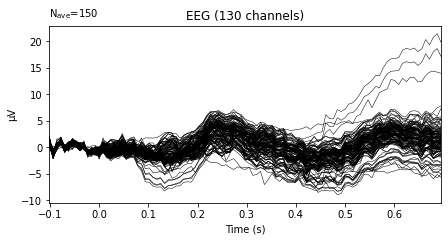

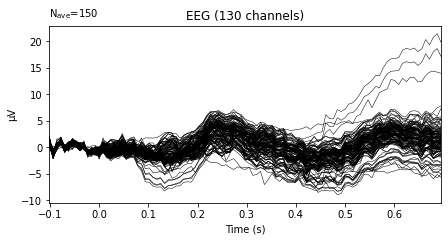

In [103]:
epochs_hiCloze.average().plot()

## Load stimuli

In [4]:
stim_paths = list(STIM_DIR.glob("*.mat"))
stim_df = pd.concat([utils.load_stimuli(path) for path in stim_paths],
                    keys=[int(p.stem.replace("Run", "")) for p in stim_paths],
                    names=["item", "content_word_idx"]).sort_index()
stim_df

word  onset_time  offset_time
item content_word_idx                                    
1    0                       OLD        1.12         1.41
     1                       MAN        1.41         1.79
     2                    FISHED        2.08         2.41
     3                     ALONE        2.41         2.77
     4                     SKIFF        2.95         3.41
...                          ...         ...          ...
20   250               NECESSARY      184.43       184.93
     251                    FREE      185.06       185.42
     252                   UNTIE      185.56       186.00
     253                 VARIOUS      186.11       186.57
     254                   LINES      186.57       187.07

[5459 rows x 3 columns]

### Align stimuli with original text and surprisals

We will simultaneously run this alignment, accounting for differences in tokenization and in words missing in the stimuli (which only contain "content words").

In [5]:
sentences = nltk.tokenize.PunktSentenceTokenizer().tokenize(FULL_TEXT_PATH.open().read())
sentences = [nltk.tokenize.RegexpTokenizer("[\w']+|[^\w\s]+").tokenize(sent) for sent in sentences]
tokens_flat = [tok for sent in sentences for tok in sent]

In [6]:
## Align stimulus rows with full text content, in preparation
## for re-inserting non-content words.

punct_re = re.compile(r"[^A-Za-z]")

stop = False

tok_cursor = 0
surp_cursor = 0

tok_el = tokens_flat[tok_cursor]
# surp_el = surprisals_df.iloc[surp_cursor]

# For each element in surp_df, record the index of the corresponding element
# in the token sequence or surprisal df.
tok_pos, surp_pos = [], []
for item, rows in tqdm(stim_df.groupby("item")):
    if stop: break
        
    # print("==========", item)
    for idx, row in rows.iterrows():
        # print(row.word, "::")
        
        # Track how many elements in a reference we have skipped. If this is excessive,
        # we'll quit rather than looping infinitely.
        skip_count = 0
        if stop: break
        
        # Find corresponding token in text and append to `tok_pos`.
        try:
            tok_el = punct_re.sub("", tok_el)
            while not tok_el.startswith(row.word.lower()):
                tok_cursor += 1
                skip_count += 1
                if skip_count > 20:
                    stop = True
                    break
                
                tok_el = utils.strip_accents(tokens_flat[tok_cursor].lower())
                # print("\t//", element)
                
            # print("\tMatch", row.word, element)
            tok_pos.append(tok_cursor)

            # If we matched only a subset of the token, then cut off what we
            # matched and proceed.
            if tok_el != row.word.lower():
                tok_el = tok_el[len(row.word):]
        except IndexError:
            print("iex", row, tok_cursor, tok_el)
            stop = True
            break
        
#         surp_word = punct_re.sub("", surp_el.token)
#         while not surp_el.token == row.word.lower():
#             surp_cursor += 1
#             skip_count += 1
#             if skip_count > 20:
#                 stop = True
#                 break
                
#             surp_el = surprisals_df.iloc[surp_cursor]
            
#         print("\tSurp match", row.word, surp_cursor, surp_el.token)
#         surp_pos.append(surp_cursor)
        
        # DEV
        # if tok_cursor > 50:
        #     stop = True
            
stim_df["tok_pos"] = tok_pos

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
if RECOMPUTE_SURPRISALS:
    hf_tokenizer = transformers.AutoTokenizer.from_pretrained(SURPRISALS_HF_MODEL)
    hf_model = transformers.AutoModelForCausalLM.from_pretrained(SURPRISALS_HF_MODEL,
                                                                 add_cross_attention=True, is_decoder=True)

    tokenized = hf_tokenizer.batch_encode_plus(
        [" ".join(sentence) for sentence in sentences],
        add_special_tokens=True, return_offsets_mapping=True)

    global_tok_cursor = 0

    # Each element is of form (global_text_tok_idx, sent_idx, text_tok_idx, tok_idx, surprisal)
    # `global_text_tok_idx` is an index into `tokens_flat`
    # `sent_idx` is an index into `sentences`
    # `text_tok_idx` is an index into `sentences[sent_idx]`
    surp_mapping = []
    for sent_idx, sentence in enumerate(tqdm(sentences)):
        sent_tokens = torch.tensor(tokenized["input_ids"][sent_idx]).unsqueeze(0)

        # Run batches of decoding, accounting for limited sequence input size
        max_len = 512
        past = None
        input_ids = sent_tokens.clone()
        surprisal_outputs = []
        while True:
            with torch.no_grad():
                outputs_b = hf_model(
                    input_ids=input_ids[:, :max_len],
                    past_key_values=past,
                    return_dict=True)

            # at most max_len * vocab_size
            surprisal_outputs.append(-outputs_b["logits"].log_softmax(dim=2).squeeze(0).numpy())

            past = outputs_b["past_key_values"]

            if input_ids.shape[1] <= max_len:
                # Done.
                break
            else:
                input_ids = input_ids[:, max_len:]

        # T * vocab_size
        all_surprisals = np.concatenate(surprisal_outputs, axis=0)

        # get surprisals of expected words
        surps_shifted = all_surprisals[:-1, :]
        sent_tokens_shifted = sent_tokens.squeeze()[1:]
        token_surps = surps_shifted[range(surps_shifted.shape[0]), sent_tokens_shifted]

        word_ids = tokenized.word_ids(sent_idx)
        for tok_id, surp in enumerate(token_surps):
            if word_ids[tok_id] is None:
                continue
            surp_mapping.append((global_tok_cursor + word_ids[tok_id],
                                 sent_idx, word_ids[tok_id], tok_id, surp))

        global_tok_cursor += len(sentence)

    surp_mapping = pd.DataFrame(surp_mapping, columns=["global_text_tok_idx", "sent_idx",
                                                       "text_tok_idx", "tok_idx", "surprisal"])
    
    surp_mapping.to_csv(SURPRISALS_CHECKPOINT_PATH)
else:
    surp_mapping = pd.read_csv(SURPRISALS_CHECKPOINT_PATH)

### Merge into `stim_df`

In [8]:
surp_mapping["token"] = surp_mapping.global_text_tok_idx.map(dict(enumerate(tokens_flat)))

In [9]:
surp_mapping.groupby(["global_text_tok_idx", "token"]).surprisal.sum()

global_text_tok_idx  token  
0                    He         2.660097
1                    was        3.965186
2                    an         3.409394
3                    old        1.007797
4                    man        2.824772
                                  ...   
12814                and        8.506883
12815                untie      3.200993
12816                the        7.338224
12817                various    6.563997
12818                lines      8.991981
Name: surprisal, Length: 12111, dtype: float64

In [10]:
stim_df = pd.merge(stim_df, surp_mapping.groupby(["global_text_tok_idx"]).surprisal.sum(),
                   how="left", left_on="tok_pos", right_index=True)

### Compute EEG sample points

In [11]:
# Compute the nearest following sample for each word onset.
stim_df["sample_id"] = np.ceil(stim_df.onset_time * SAMPLE_RATE).astype(int)

## Load envelope data

In [12]:
# TODO why don't envelope seq and data seq match in shape ?
# want to eventually insert envelope as an extra channel in the `Raw`
# so that it gets transformed correctly during epoching

## EEG analysis

We'll manually create MNE representations from the raw data given in the dataset.

In [52]:
info_re = re.compile(r"Subject(\d+)_Run(\d+)\.mat")

# subject ID -> paths list
eeg_paths = {k: list(v) for k, v in itertools.groupby(sorted(EEG_DIR.glob("**/*.mat")),
                                                      lambda p: info_re.match(p.name).group(1))}

In [53]:
def run(idx, *args, **kwargs):
    print("==========", idx)
    return utils.run_n400(*args, **kwargs)
n400_dfs = {subject: run(subject, paths, data_channels, reference_channels,
                         sample_rate=SAMPLE_RATE,
                         stim_df=stim_df,
                         filter_low=FILTER_LOW, filter_high=FILTER_HIGH,
                         epoch_window=EPOCH_WINDOW,
                         test_window=TEST_WINDOW)
            for subject, paths in tqdm(list(eeg_paths.items()))}

  0%|          | 0/19 [00:00<?, ?it/s]

========== 1
Creating RawArray with float64 data, n_channels=130, n_times=22949
    Range : 0 ... 22948 =      0.000 ...   179.281 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=23546
    Range : 0 ... 23545 =      0.000 ...   183.945 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=23602
    Range : 0 ... 23601 =      0.000 ...   184.383 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=23635
    Range : 0 ... 23634 =      0.000 ...   184.641 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=23614
    Range : 0 ... 23613 =      0.000 ...   184.477 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=26399
    Range : 0 ... 26398 =      0.000 ...   206.234 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=21439
    Range : 0 ... 21438 =      0.000 ...   167.484 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=22421
    Range 

In [64]:
n400_df = pd.concat(n400_dfs, names=["subject"])

In [65]:
n400_df

item  content_word_idx       word  onset_time  offset_time  \
subject                                                                    
1       0        1                 0        OLD        1.12         1.41   
        1        1                 1        MAN        1.41         1.79   
        2        1                 2     FISHED        2.08         2.41   
        3        1                 3      ALONE        2.41         2.77   
        4        1                 4      SKIFF        2.95         3.41   
...            ...               ...        ...         ...          ...   
9       5454    20               250  NECESSARY      184.43       184.93   
        5455    20               251       FREE      185.06       185.42   
        5456    20               252      UNTIE      185.56       186.00   
        5457    20               253    VARIOUS      186.11       186.57   
        5458    20               254      LINES      186.57       187.07   

              tok_pos  surprisal  sample_id condition  epoch  ...       V121  \
subject                                                       ...              
1       0           3   1.007797        144         2      0  ...  -6.535537   
        1           4   2.824772        181         2      1  ...  -0.973546   
        2           6   9.653991        267         2      2  ...   1.809570   
        3           7   2.077590        309         2      3  ...  -1.002909   
        4          10   3.006370        378         2      4  ...  -0.130411   
...               ...        ...        ...       ...    ...  ...        ...   
9       5454    12811   0.505702      23608         2   5454  ... -30.215660   
        5455    12813   5.136990      23688         2   5455  ...  22.050487   
        5456    12815   3.200993      23752         2   5456  ... -17.571654   
        5457    12817   6.563997      23823         2   5457  ...   3.709026   
        5458    12818   8.991981      23881         2   5458  ...   1.097245   

                   V122       V123       V124       V125       V126  \
subject                                                               
1       0     -3.559695   1.043726  -0.722162  10.053437   0.280319   
        1     -4.187239  -6.280353  -1.339946  -0.307634  -5.661799   
        2      0.537990   1.725029  -0.930842  -1.458147 -11.151710   
        3      1.841617   0.946889   2.122226  -0.610409  -2.730156   
        4     -0.640357  -1.844666  -1.453407  -1.617477   0.564027   
...                 ...        ...        ...        ...        ...   
9       5454 -30.762298 -28.536836 -24.771822 -29.727393 -30.329646   
        5455  20.715272  21.175673  18.956435  29.901126  26.990445   
        5456 -16.718291 -17.069853 -16.428728 -26.518188 -24.027427   
        5457   3.546814   4.591386   7.176206  15.318439   9.182653   
        5458   2.132146   0.702951  -0.987972  -2.734973  -0.586353   

                   V127       V128         M1         M2  
subject                                                   
1       0      6.409197   7.820706   0.010072  -0.010072  
        1     -5.323573  -8.680225  -0.029944   0.029944  
        2      0.037070  -9.243201  -0.011114   0.011114  
        3      2.641442   6.990103   0.040070  -0.040070  
        4     -3.037194  -5.637923   0.058072  -0.058072  
...                 ...        ...        ...        ...  
9       5454 -30.629597 -30.517738  -8.647543   8.647543  
        5455  25.193935  23.781331  13.799923 -13.799923  
        5456 -22.471782 -21.097836 -15.542304  15.542304  
        5457   6.470891   5.351600  -1.828366   1.828366  
        5458   0.339929   0.614770   4.226391  -4.226391  

[103721 rows x 140 columns]

### Demo with one subject

In [69]:
# Dummy corr check: correlation between word length and 400ms baselined response

id_vars = ["subject", "word", "surprisal", "epoch", "item"]
electrode_corrs = n400_df.reset_index()[id_vars + data_channels] \
    .melt(id_vars=id_vars, var_name="electrode") \
    .dropna() \
    .groupby(["subject", "electrode"]).apply(lambda xs: np.corrcoef(xs.surprisal, xs.value)[0, 1])
electrode_corrs.sort_values().head(20)

subject  electrode
13       V73         -0.046153
16       V26         -0.045346
13       V74         -0.045140
16       V52         -0.043194
         V53         -0.043001
13       V18         -0.042964
16       V97         -0.042763
10       V59         -0.042702
16       V33         -0.042675
10       V60         -0.042537
16       V3          -0.042386
         V65         -0.042111
10       V61         -0.042051
16       V1          -0.041727
         V50         -0.041675
10       V58         -0.041641
16       V54         -0.041583
13       V5          -0.041518
16       V35         -0.041490
         V111        -0.041351
dtype: float64

In [71]:
electrode_corrs.sort_values().tail(20)

subject  electrode
1        V18          0.021490
         V124         0.021504
         V117         0.022059
         V116         0.022160
         V97          0.022286
         V127         0.022576
         V122         0.023146
         V106         0.023155
         V10          0.023255
         V108         0.023259
7        V41          0.023499
1        V107         0.024275
         V9           0.025119
         V115         0.026101
         V12          0.026385
         V5           0.027776
         V114         0.028582
         V126         0.030920
         V105         0.032100
         V123         0.032122
dtype: float64

<AxesSubplot:ylabel='Frequency'>

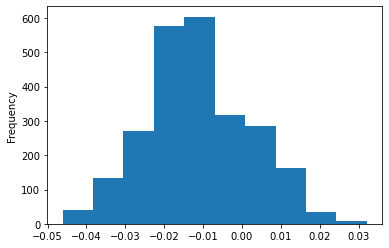

In [70]:
electrode_corrs.plot.hist()